Load libraries

In [1]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
import matplotlib.pyplot as plt

import random
from PIL import Image
import os
import base64
import io
import sys
import time
import requests
import re
from tqdm import tqdm

from typing import List, Dict

random.seed(2024)
torch.manual_seed(2024)
device = "cuda" if torch.cuda.is_available() else "cpu"

C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load images

In [2]:
path_to_images = "../cards/odissey_cards"
deck = []

for image_name in os.listdir(path_to_images):
    image_number = int(image_name.split(".")[0])
    image = Image.open(os.path.join(path_to_images, image_name)).convert("RGB")
    image = image.resize((224,224))
    deck.append(image)

Define GPT and naive players

In [3]:
class GPT():
    def __init__(self, api_key: str):
        
        self.api_key = api_key
        self.headers = {"Content-Type": "application/json", "Authorization": f"Bearer {self.api_key}"}

    def encode_image(self, image: Image.Image) -> str:
        buffered = io.BytesIO()
        image.save(buffered, format="PNG") 
        image_bytes = buffered.getvalue()
        return base64.b64encode(image_bytes).decode('utf-8')
    
    def select_card_from_caption(self, images: List[Image.Image], caption: str) -> int:
        
        base64_cards = [self.encode_image(image) for image in images]
        messages = [
            {
                "role": "system",
                "content": "You are playing a game of Dixit. Your task is to select the best matching card for a given story prompt from the images provided. Return the index of the selected card as a number between 0 and N-1, where N is the number of cards."
            },
            {
                "role": "user",
                "content": f"The story prompt is: {caption}."
            }
        ]

        for idx, base64_image in enumerate(base64_cards):
            messages.append({
                "role": "user",
                "content": [{
                        "type": "text",
                        "text": f"This is card with index {idx}"
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
                    }
                ]
            })

        data = {
            "model": "gpt-4o-mini",
            "messages": messages
        }

        max_retries = 3
        retries = 0

        while retries < max_retries:

            try:
                response = requests.post('https://api.openai.com/v1/chat/completions', headers=self.headers, json=data)
                response = response.json()

                content = response['choices'][0]["message"]['content']
                match = re.search(r'\d+', content)
                index = int(match.group())  

                return index
            
            except Exception as e:
                print(e)
                retries += 1

                time.sleep(retries * 60)

        print("MAXIMUM RETRIES NUMBER REACHED. GPT IS NOT AVAILABLE AT THE MOMENT. RETRY LATER.")
        sys.exit(1)

class Naive():
    def __init__(self):
        pass

    def select_card_from_caption(self, images: List[Image.Image], caption: str) -> int:
        return random.randint(0, len(images)-1)

Defining game environment:
 - Sample 6 images from the deck
 - Pick randomly a correct card among the six
 - Make the BLIP model create a caption for it
 - Feed the images and the caption to both model and compute scores
 - When the deck has no cards anymore, we start a new iteration

In [5]:
def play(iterations: int, n_samples: int, gpt: GPT, naive: Naive, deck: List[Image.Image], blip_processor: BlipProcessor, blip_model: BlipForConditionalGeneration) -> Dict[str, Dict[str, float]]:
    tot = 0
    gpt_corrects = 0
    naive_corrects = 0
    for _ in tqdm(range(iterations)):
        deck_copy = list(deck)
        while len(deck_copy) > 0:
            images = random.sample(deck_copy, n_samples)
            for img in images:
                deck_copy.remove(img)

            correct_index = random.randrange(len(images))
            correct_image = images[correct_index]

            inputs = blip_processor(correct_image, return_tensors="pt").to(device)

            with torch.no_grad():
                caption_ids = blip_model.generate(
                    **inputs,
                    max_length=50, 
                    num_return_sequences=1,
                    do_sample=True,
                    top_k=50,      
                    top_p=0.95,    
                    temperature=0.7,
                    repetition_penalty=1.2, 
                    no_repeat_ngram_size=3 
                )

            caption = blip_processor.decode(caption_ids[0], skip_special_tokens=True)

            gpt_index = gpt.select_card_from_caption(images, caption)
            naive_index = naive.select_card_from_caption(images, caption)

            gpt_corrects += gpt_index == correct_index
            naive_corrects += naive_index == correct_index
            tot += 1

    return {"GPT": {"corrects": gpt_corrects/tot, "wrong": 1 - (gpt_corrects/tot)}, "Naive": {"corrects": naive_corrects/tot, "wrong": 1 - (naive_corrects/tot)}}


Define models and parameters to perform a simulation

**Note** If we select 6 cards from the deck, to finish a deck we will have to select those six cards 14 times.

In [6]:
iterations = 10 # 14 times x iteration. 14 x 10 = 140 total hands to pass to GPT
n_samples = 6
gpt = GPT("") #Insert API key
naive = Naive()

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

blip_model.load_state_dict(torch.load("../weights/rephrased_blip(2nd)/epoch50.pt"))
blip_model.eval()

C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

Perform a simulation

In [7]:
results = play(iterations, n_samples, gpt, naive, deck, blip_processor, blip_model)

100%|██████████| 10/10 [15:23<00:00, 92.35s/it]


Plot the results

Model     Corrects  Wrongs    
------------------------------
GPT       0.37      0.63      
Naive     0.14      0.86      


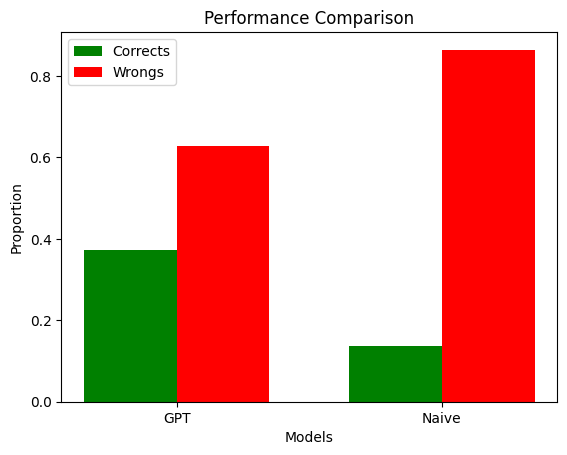

In [8]:
def plot_results(results: Dict[str, Dict[str, float]]):
    labels = list(results.keys()) 
    corrects = [results[label]["corrects"] for label in labels]
    wrongs = [results[label]["wrong"] for label in labels]

    bar_width = 0.35
    index = range(len(labels))

    plt.bar(index, corrects, bar_width, label='Corrects', color='g')
    plt.bar([i + bar_width for i in index], wrongs, bar_width, label='Wrongs', color='r')

    plt.xlabel('Models')
    plt.ylabel('Proportion')
    plt.title('Performance Comparison')
    plt.xticks([i + bar_width / 2 for i in index], labels)
    plt.legend()

    plt.show()

def pretty_print(results: dict):
    
    print(f"{'Model':<10}{'Corrects':<10}{'Wrongs':<10}")
    print("-" * 30)
    
    for model, scores in results.items():
        corrects = f"{scores['corrects']:.2f}"
        wrongs = f"{scores['wrong']:.2f}"
        print(f"{model:<10}{corrects:<10}{wrongs:<10}")

pretty_print(results)
plot_results(results)